# New baseline for the bovine with Transformers

inspired from this guide :
https://keras.io/examples/vision/video_transformers/

In [2]:
import matplotlib.pyplot as plt

In [3]:
from problem import get_train_data, get_test_data, WeightedClassificationError

In [4]:
import numpy as np
#CPU
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
import tensorflow as tf
from time import time
import pandas as pd
import math

In [5]:
import io
import imageio
import ipywidgets 

In [6]:
from tensorflow.keras import layers
from tensorflow import keras

In [7]:
# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

## Define hyperparams

In [8]:
# DATA
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (30, 226, 226, 1)
NUM_CLASSES = 8

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 160

# TUBELET EMBEDDING
PATCH_SIZE = (9, 60, 60)
STRIDES= tuple(list(map(lambda x:x//2, PATCH_SIZE)))
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 10


In [9]:
STRIDES

(4, 30, 30)

## Data preparation

In [10]:
videos_train, labels_train = get_train_data()

In [11]:
X_for_classifier= np.array(videos_train)
y_for_classifier= labels_train

In [12]:
videos_test, labels_test  = get_test_data()

In [13]:
Xtest_for_classifier = np.array(videos_test)
ytest_for_classifier = labels_test

In [14]:
from PIL import Image

def resize_frames(video):
    res=[]
    for frame in video:
        resized_img=Image.fromarray(frame).resize(INPUT_SHAPE[1:3])
        res.append(np.array(resized_img))
    return np.array(res)

In [15]:
#function that gets all dataset
# 30 frames per video for 177 video = 2.65 gb !if considering each frame of float64
# as uint8 it takes 0.33 gb

def gen_videos(videolist):
    newvideos=[] # 177*30*250*250
    for video in videolist:
        reducedvideo= video.read_samples(video.frame_times[0:299:10])
        reducedvideo= reducedvideo.astype('uint8')        
        #CROP from 250 to 224
        reducedvideo=resize_frames(reducedvideo)
        #and add a batch dimension. dim= 1*30*250*250*3
        #reducedvideo = reducedvideo[None, ...]

        newvideos.append(reducedvideo)
    return newvideos

In [16]:
X_for_classifier= np.array(gen_videos(X_for_classifier))
X_for_classifier.shape

(177, 30, 226, 226)

In [17]:
Xtest_for_classifier= np.array(gen_videos(Xtest_for_classifier))
Xtest_for_classifier.shape

(100, 30, 226, 226)

In [18]:
train_videos=X_for_classifier
test_videos=Xtest_for_classifier
train_videos.shape

(177, 30, 226, 226)

In [19]:
def class_to_int(argument):
    switcher = {
        'A':0,
        'B':1,
        'C':2,
        'D':3,
        'E':4,
        'F':5,
        'G':6,
        'H':7,
    }
 
    # get() method of dictionary data type returns
    # value of passed argument if it is present
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(argument, "nothing")
 

In [20]:
func=np.vectorize(class_to_int)
#Train
train_labels=func(y_for_classifier)
#Test
test_labels=func(ytest_for_classifier)

In [21]:
@tf.function
def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )

    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
testloader = prepare_dataloader(test_videos, test_labels, "test")



In [22]:
import sys
sys.getsizeof(trainloader )

48

In [23]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size,strides, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=strides,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)

        return flattened_patches

In [24]:
from keras.layers import Input
from keras.models import Model

inp = Input(shape=INPUT_SHAPE)
out = TubeletEmbedding(
    embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE, strides=STRIDES
)(inp)
model = Model(inp, out)

output = model.predict(trainloader)

6/6 [==============================] - 6s 40ms/step


In [25]:
output.shape

(177, 216, 128)

In [26]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens




In [27]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model



In [28]:
def run_experiment():
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE, strides=STRIDES
        ),
        positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
    )

    # Compile the model with the optimizer, loss function
    # and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model.
    _ = model.fit(trainloader, epochs=EPOCHS)

    _, accuracy, top_5_accuracy = model.evaluate(testloader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return model


model = run_experiment()



Epoch 1/160
6/6 [==============================] - 11s 171ms/step - loss: 2.2065 - accuracy: 0.2034 - top-5-accuracy: 0.7345
Epoch 2/160
6/6 [==============================] - 1s 156ms/step - loss: 2.0570 - accuracy: 0.2486 - top-5-accuracy: 0.7458
Epoch 3/160
6/6 [==============================] - 1s 161ms/step - loss: 2.0143 - accuracy: 0.2147 - top-5-accuracy: 0.7684
Epoch 4/160
6/6 [==============================] - 1s 160ms/step - loss: 1.9961 - accuracy: 0.2260 - top-5-accuracy: 0.7853
Epoch 5/160
6/6 [==============================] - 1s 157ms/step - loss: 1.9972 - accuracy: 0.2203 - top-5-accuracy: 0.7740
Epoch 6/160
6/6 [==============================] - 1s 157ms/step - loss: 1.9865 - accuracy: 0.2147 - top-5-accuracy: 0.7571
Epoch 7/160
6/6 [==============================] - 1s 164ms/step - loss: 1.9763 - accuracy: 0.2429 - top-5-accuracy: 0.8136
Epoch 8/160
6/6 [==============================] - 1s 158ms/step - loss: 1.9710 - accuracy: 0.2486 - top-5-accuracy: 0.7966
Epoch 9

6/6 [==============================] - 1s 155ms/step - loss: 0.9744 - accuracy: 0.6554 - top-5-accuracy: 0.9605
Epoch 132/160
6/6 [==============================] - 1s 158ms/step - loss: 0.9859 - accuracy: 0.6441 - top-5-accuracy: 0.9435
Epoch 133/160
6/6 [==============================] - 1s 157ms/step - loss: 0.9499 - accuracy: 0.6554 - top-5-accuracy: 0.9492
Epoch 134/160
6/6 [==============================] - 1s 162ms/step - loss: 0.8857 - accuracy: 0.6610 - top-5-accuracy: 0.9605
Epoch 135/160
6/6 [==============================] - 1s 166ms/step - loss: 0.8052 - accuracy: 0.7062 - top-5-accuracy: 0.9774
Epoch 136/160
6/6 [==============================] - 1s 161ms/step - loss: 0.7711 - accuracy: 0.7458 - top-5-accuracy: 0.9887
Epoch 137/160
6/6 [==============================] - 1s 155ms/step - loss: 0.8104 - accuracy: 0.7232 - top-5-accuracy: 0.9605
Epoch 138/160
6/6 [==============================] - 1s 156ms/step - loss: 0.7404 - accuracy: 0.7514 - top-5-accuracy: 0.9774
Epoch 

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 226, 22  0           []                               
                                6, 1)]                                                            
                                                                                                  
 tubelet_embedding_1 (TubeletEm  (None, 216, 128)    4147328     ['input_2[0][0]']                
 bedding)                                                                                         
                                                                                                  
 positional_encoder (Positional  (None, 216, 128)    27648       ['tubelet_embedding_1[0][0]']    
 Encoder)                                                                                   

 multi_head_attention_4 (MultiH  (None, 216, 128)    66048       ['layer_normalization_8[0][0]',  
 eadAttention)                                                    'layer_normalization_8[0][0]']  
                                                                                                  
 add_8 (Add)                    (None, 216, 128)     0           ['multi_head_attention_4[0][0]', 
                                                                  'add_7[0][0]']                  
                                                                                                  
 layer_normalization_9 (LayerNo  (None, 216, 128)    256         ['add_8[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 sequential_4 (Sequential)      (None, 216, 128)     131712      ['layer_normalization_9[0][0]']  
          

 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_9 (MultiH  (None, 216, 128)    66048       ['layer_normalization_18[0][0]', 
 eadAttention)                                                    'layer_normalization_18[0][0]'] 
                                                                                                  
 add_18 (Add)                   (None, 216, 128)     0           ['multi_head_attention_9[0][0]', 
                                                                  'add_17[0][0]']                 
                                                                                                  
 layer_normalization_19 (LayerN  (None, 216, 128)    256         ['add_18[0][0]']                 
 ormalization)                                                                                    
          

In [30]:
NUM_SAMPLES_VIZ = 25
testsamples, labels = next(iter(testloader))
print(testsamples.shape)
print(labels)

testsamples, labels = testsamples[:NUM_SAMPLES_VIZ], labels[:NUM_SAMPLES_VIZ]

ground_truths = []
preds = []
videos = []

for i, (testsample, label) in enumerate(zip(testsamples, labels)):
    # Generate gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, (testsample.numpy() * 255).astype("uint8"), "GIF", fps=5)
        videos.append(gif.getvalue())

    # Get model prediction
    output = model.predict(tf.expand_dims(testsample, axis=0))[0]
    pred = np.argmax(output, axis=0)

    ground_truths.append(label.numpy().astype("int"))
    preds.append(pred)


def make_box_for_grid(image_widget, fit):
    """Make a VBox to hold caption/image for demonstrating option_fit values.

    Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
    """
    # Make the caption
    if fit is not None:
        fit_str = "'{}'".format(fit)
    else:
        fit_str = str(fit)

    h = ipywidgets.HTML(value="" + str(fit_str) + "")

    # Make the green box with the image widget inside it
    boxb = ipywidgets.widgets.Box()
    boxb.children = [image_widget]

    # Compose into a vertical box
    vb = ipywidgets.widgets.VBox()
    vb.layout.align_items = "center"
    vb.children = [h, boxb]
    return vb


boxes = []
for i in range(NUM_SAMPLES_VIZ):
    ib = ipywidgets.widgets.Image(value=videos[i], width=100, height=100)
    true_class = str(ground_truths[i])
    pred_class = str(preds[i])
    caption = f"T: {true_class} | P: {pred_class}"

    boxes.append(make_box_for_grid(ib, caption))

ipywidgets.widgets.GridBox(
    boxes, layout=ipywidgets.widgets.Layout(grid_template_columns="repeat(5, 200px)")
)

(32, 30, 226, 226, 1)
tf.Tensor(
[0. 0. 6. 0. 5. 2. 7. 2. 2. 7. 7. 5. 7. 7. 4. 4. 4. 2. 2. 6. 7. 7. 7. 4.
 6. 4. 3. 3. 6. 6. 5. 6.], shape=(32,), dtype=float32)
1/1 [==============================] - 0s 68ms/step


GridBox(children=(VBox(children=(HTML(value="'T: 0 | P: 7'"), Box(children=(Image(value=b'GIF89a\xe2\x00\xe2\x…

In [31]:
pred= model.predict(testloader)

4/4 [==============================] - 1s 53ms/step


In [32]:
np.array(preds).shape

(25,)

In [33]:
ground_truths = []
preds = []
videos = []
for test in testloader:
    testsamples, labels = next(iter(testloader))
    for i, (testsample, label) in enumerate(zip(testsamples, labels)):
        # Get model prediction
        output = model.predict(tf.expand_dims(testsample, axis=0))[0]
        pred = np.argmax(output, axis=0)

        ground_truths.append(label.numpy().astype("int"))
        preds.append(pred)

1/1 [==============================] - 0s 46ms/step


In [34]:
np.array(preds).shape

(128,)

In [35]:
preds

[7,
 7,
 7,
 5,
 5,
 2,
 0,
 5,
 5,
 7,
 2,
 1,
 7,
 0,
 6,
 5,
 5,
 0,
 2,
 2,
 5,
 5,
 7,
 7,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 2,
 0,
 5,
 5,
 7,
 2,
 1,
 7,
 0,
 6,
 5,
 5,
 0,
 2,
 2,
 5,
 5,
 7,
 7,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 2,
 0,
 5,
 5,
 7,
 2,
 1,
 7,
 0,
 6,
 5,
 5,
 0,
 2,
 2,
 5,
 5,
 7,
 7,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 2,
 0,
 5,
 5,
 7,
 2,
 1,
 7,
 0,
 6,
 5,
 5,
 0,
 2,
 2,
 5,
 5,
 7,
 7,
 5,
 5,
 7,
 7,
 7,
 5,
 5,
 5]

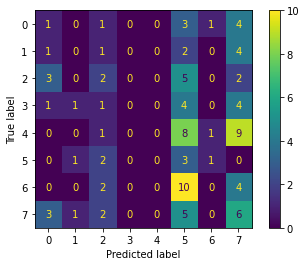

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(test_labels, preds[:100])
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

In [37]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, preds[:100],labels=[0,1,2,3,4,5,6,7]))

              precision    recall  f1-score   support

           0       0.11      0.10      0.11        10
           1       0.00      0.00      0.00         8
           2       0.17      0.17      0.17        12
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        19
           5       0.07      0.43      0.13         7
           6       0.00      0.00      0.00        16
           7       0.18      0.35      0.24        17

    accuracy                           0.12       100
   macro avg       0.07      0.13      0.08       100
weighted avg       0.07      0.12      0.08       100



C:\Users\Jacobo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jacobo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jacobo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
